In [1]:
import mne
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from typing import Dict, Optional, Tuple, Sequence, Iterator

In [2]:
with open("../../0_set_up_and_raw_data/data/subject_numbers.txt") as f:
    subject_numbers = [line.strip() for line in f if line.strip()]

KeyType = Tuple[str, str, str]
    
def condition_keys() -> Iterator[KeyType]:
    for talker in ["S", "T"]:
        for meaning in ["M", "N"]:
            for constraint in ["L", "H"]:
                key = (talker, meaning, constraint)
                yield key
                
def import_eeg_data(subject):
    fp = os.path.join('../data', subject, 'eeg_data_averaged.csv')
    data = pd.read_csv(fp, delimiter = ',')
    return data

def import_cross_correlations():
    fp = os.path.join('../../2_cross_correlate/data/average.csv')
    data = pd.read_csv(fp, delimiter = ',')
    return data

def subset_by_condition(data, condition):
    data = data[(data.talker == condition[0]) &
               (data.meaning == condition[1]) &
               (data.constraint == condition[2])]
    return data

def remove_label_vars(data):
    data = data.drop(["talker", "meaning", "constraint", "channel"], axis = 1)
    return data

def get_evoked(data):
    # provide metadata
    sampling_freq = 1000 # in Hertz
    start_time = -.1 # time at beginning of file

    # make MNE object for ERP
    dig = mne.channels.make_standard_montage('GSN-HydroCel-128')
    info = mne.create_info(dig.ch_names, ch_types = 'eeg', sfreq = sampling_freq)
    info.set_montage('GSN-HydroCel-128')
    evoked = mne.EvokedArray(data*1e-6, info, tmin = start_time)

    # low-pass filter at 30 Hz
    evoked.filter(l_freq = None, h_freq = 30.) 
    evoked.crop(tmin = 0.75, tmax = 1.25)
    return evoked

def plot_eeg(evoked):    
    evoked.plot_joint(ts_args = {'gfp': True})

def get_n1(evoked):
    # crop around N1
#     evoked.crop(tmin = 0.75, tmax = 1.25) # crops global var

    # get gfp and n1 max
    gfp = evoked.data
    gfp = np.std(gfp, axis = 0)
    n1_magnitude = np.max(gfp)
    return n1_magnitude

def get_parietal_rms(evoked):
    left_sup_parietal = [53, 54, 61]
    gfp = evoked.data[left_sup_parietal]
    gfp_mean = np.mean(gfp, axis = 0)
    parietal_rms = get_rms(gfp_mean)
    return parietal_rms
    
def get_rms(x):
    rms = np.sqrt(np.mean(x**2))
    return rms

def get_condition_df(df, labels, condition):
    condition_df = df[labels == condition]
    condition_df = condition_df.groupby('subject_number', as_index = False).mean()
    return(condition_df)

def get_condition_rms_n1(df, labels, condition):
    condition_df = df[labels == condition]
    condition_df = condition_df.groupby('subject_number', as_index = False)['n1_magnitude', 'rms'].mean()
    return(condition_df)

In [3]:
# initialize data frame
df: Dict[str, float] = {
    'subject_number': [],
    'talker': [],
    'meaning': [],
    'constraint': [],
    'n1_magnitude': [],
    'rms': [],
}

# compute n1 magnitude and rms
n1_magnitudes = []
for subject in subject_numbers:
    for condition in condition_keys():
        # get data
        data = import_eeg_data(subject)
        data = subset_by_condition(data, condition)
        data = remove_label_vars(data)
        evoked = get_evoked(data)
        
        # compute stats
        n1_magnitude = get_n1(evoked)
        rms = get_parietal_rms(evoked)
        
        # append to dict
        df['subject_number'].append(subject)
        df['talker'].append(condition[0])
        df['meaning'].append(condition[1])
        df['constraint'].append(condition[2])
        df['n1_magnitude'].append(n1_magnitude)
        df['rms'].append(rms)
        
# convert dict to pd dataframe
df = pd.DataFrame(df)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwi


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firw


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firw


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firw


Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firw

In [4]:
# split into data frames for each condition
same = get_condition_rms_n1(df, df.talker, "S")
different = get_condition_rms_n1(df, df.talker, "T")
meaningful = get_condition_rms_n1(df, df.meaning, "M")
nonsense = get_condition_rms_n1(df, df.meaning, "N")
low = get_condition_rms_n1(df, df.constraint, "L")
high = get_condition_rms_n1(df, df.constraint, "H")

F_onewayResult(statistic=0.13425303903231395, pvalue=0.9838324251461819)

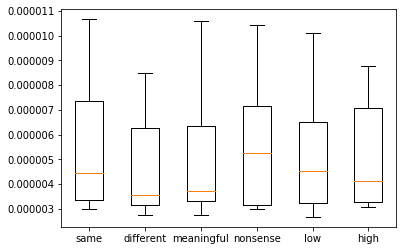

In [5]:
"""
N1 magnitude by condition
"""

df_n1 = {'same': same.n1_magnitude,
         'different': different.n1_magnitude,
         'meaningful': meaningful.n1_magnitude,
         'nonsense': nonsense.n1_magnitude,
         'low': low.n1_magnitude,
         'high': high.n1_magnitude}
fig1, ax1 = plt.subplots()
ax1.boxplot(df_n1.values())
ax1.set_xticklabels(df_n1.keys())

# ANOVA
stats.f_oneway(df_n1['same'], 
               df_n1['different'], 
               df_n1['meaningful'], 
               df_n1['nonsense'], 
               df_n1['low'], 
               df_n1['high'])

F_onewayResult(statistic=0.48706367674079115, pvalue=0.7845883889849464)

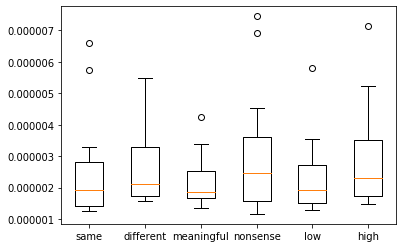

In [6]:
"""
Parietal RMS by condition
"""
df_rms = {'same': same.rms,
          'different': different.rms,
          'meaningful': meaningful.rms,
          'nonsense': nonsense.rms,
          'low': low.rms,
          'high': high.rms}
fig2, ax2 = plt.subplots()
ax2.boxplot(df_rms.values())
ax2.set_xticklabels(df_rms.keys())

# ANOVA
stats.f_oneway(df_rms['same'], 
               df_rms['different'], 
               df_rms['meaningful'], 
               df_rms['nonsense'], 
               df_rms['low'], 
               df_rms['high'])

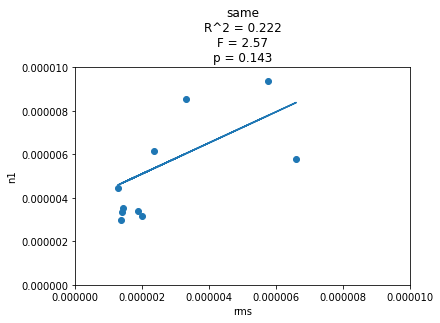

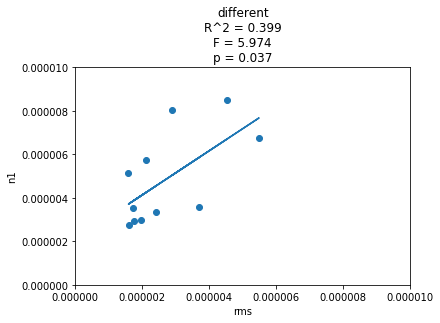

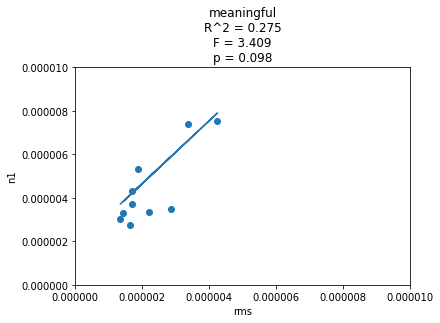

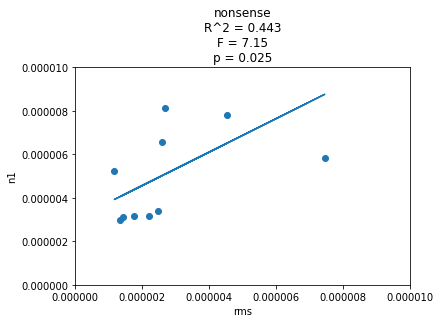

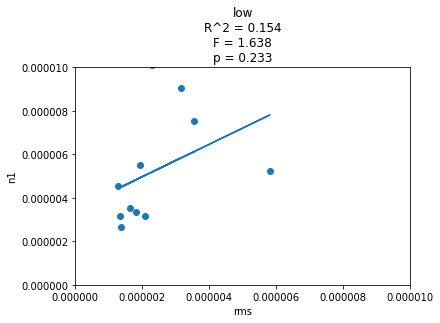

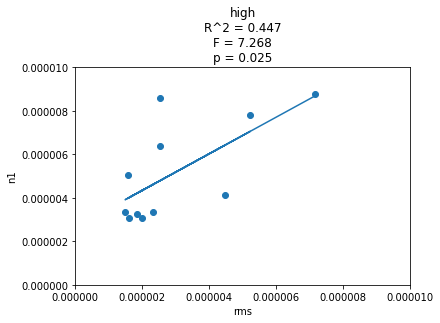

In [7]:
"""
Relationship between N1 magnitude and parietal RMS
"""
def get_x_y(condition):
    x = df_rms[condition].to_numpy()
    x = x.reshape(-1, 1)
    y = df_n1[condition].to_numpy()
    y = y.reshape(-1, 1)
    return x, y

def get_lin_reg(x, y):
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    est = model.fit()
    summary = {'b': est.params[0],
              'm': est.params[1],
              'rsq': est.rsquared,
              'f': est.fvalue,
              'f_p': est.f_pvalue}
    return summary

def plot_scatter(x, y, summary, condition):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x, summary['m']*x + summary['b'])
    plt.xlim([0, 1e-5])
    plt.ylim([0, 0.000010])
    plt.xlabel('rms')
    plt.ylabel('n1')
    plt.title(condition + "\nR^2 = " + str(round(summary['rsq'], 3)) +
              '\nF = ' + str(round(summary['f'], 3)) +
              '\np = ' + str(round(summary['f_p'], 3)))
    
conditions = ["same", "different", "meaningful", "nonsense", "low", "high"]
for condition in conditions:
    (x, y) = get_x_y(condition)
    summary = get_lin_reg(x, y)
    plot_scatter(x, y, summary, condition)

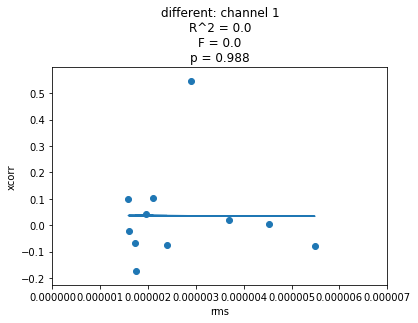

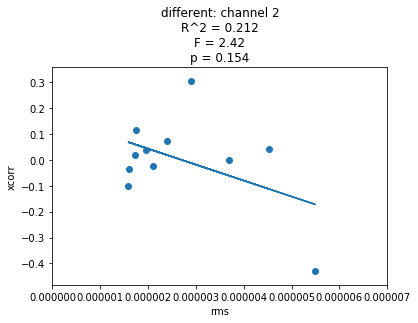

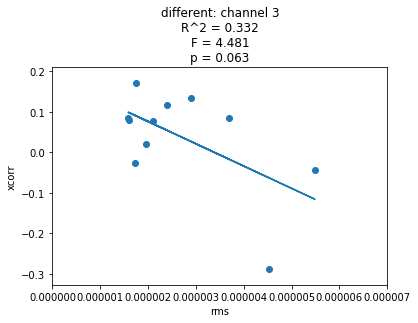

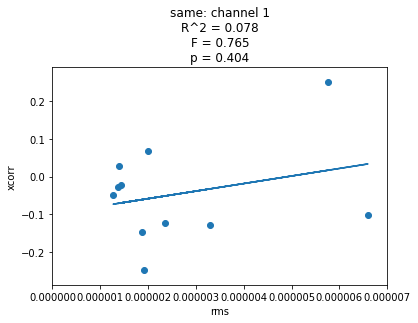

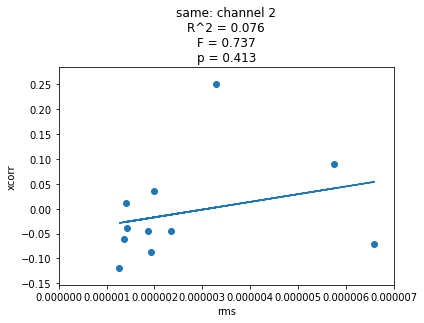

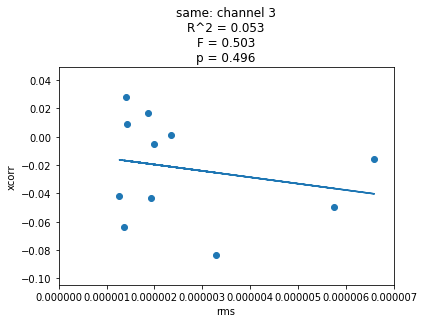

In [17]:
"""
Relationship between parietal RMS and tracking
"""

def get_x_y(df_rms, df_xcorr, channel):
    x = df_rms.to_numpy()
    x = x.reshape(-1, 1)
    y = df_xcorr[channel].to_numpy()
    y = y.reshape(-1, 1)
    return x, y

def plot_scatter(x, y, summary, condition):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x, summary['m']*x + summary['b'])
    plt.xlim([0, 0.000007])
    plt.xlabel('rms')
    plt.ylabel('xcorr')
    plt.title(condition + "\nR^2 = " + str(round(summary['rsq'], 3)) +
              '\nF = ' + str(round(summary['f'], 3)) +
              '\np = ' + str(round(summary['f_p'], 3)))

xcorr = import_cross_correlations()
xcorr = xcorr.drop(columns = 'epoch')

same_xcorr = get_condition_df(xcorr, xcorr.talker, "S")
different_xcorr = get_condition_df(xcorr, xcorr.talker, "T")
meaning_xcorr = get_condition_df(xcorr, xcorr.meaning, "M")
nonsense_xcorr = get_condition_df(xcorr, xcorr.meaning, "N")
low_xcorr = get_condition_df(xcorr, xcorr.constraint, "L")
high_xcorr = get_condition_df(xcorr, xcorr.constraint, "H")

for i in range(1, 4):
    (x, y) = get_x_y(different.rms, different_xcorr, str(i))
    summary = get_lin_reg(x, y)
    plot_scatter(x, y, summary, "different: channel " + str(i))

for i in range(1, 4):
    (x, y) = get_x_y(same.rms, same_xcorr, str(i))
    summary = get_lin_reg(x, y)
    plot_scatter(x, y, summary, "same: channel " + str(i))